In [18]:
import geopandas
import pandas
import numpy
import numpy
import math
import shapely
import plots
import matplotlib.pyplot as plt

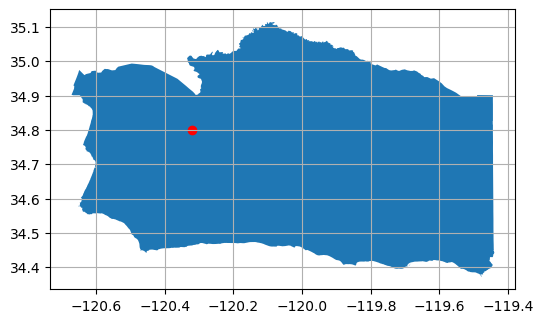

In [19]:
fig, ax = plt.subplots(dpi=100)
ax.grid(True)

polygons = geopandas.read_file('../data/santa_barbara.gpkg')

#polygons = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))#[4:5]
#polygons = polygons[polygons.name =='Germany']

polygons.plot(ax=ax)

point = numpy.array([-120.32, 34.8])

points = geopandas.GeoDataFrame([{'geom': shapely.geometry.Point(point)}]).set_geometry('geom')
points.plot(ax=ax, color='red')

In [20]:
def to_ecef(lon, lat):
    lon = numpy.array(lon)
    lat = numpy.array(lat)
    x = numpy.cos(lon/360*math.pi*2) * numpy.cos(lat/360*math.pi*2)
    y = numpy.sin(lon/360*math.pi*2) * numpy.cos(lat/360*math.pi*2)
    z = numpy.sin(lat/360*math.pi*2)
    return x, y, z

lon, lat = polygons.geometry[0][0].exterior.xy
#lon, lat = polygons.iloc[0].geometry.exterior.xy
x, y, z = to_ecef(lon, lat)
nodes = numpy.array([x,y,z]).transpose()

In [21]:
edges = []
for i in range(0, len(x)-1):
    node1 = nodes[i]
    node2 = nodes[i+1]
    gc = numpy.cross(node2, node1)
    lim1 = numpy.cross(gc, node1)
    lim2 = numpy.cross(node2, gc)
    edges.append({'node1': node1, 'node2': node2, 'gc': gc, 'lim1': lim1, 'lim2': lim2})
edges = pandas.DataFrame(edges)

In [22]:
point_ecef = to_ecef(point[0], point[1])
ray_dest = numpy.array([0, 0, 1])
ray = numpy.cross(point_ecef, ray_dest)

outbound_intersects = []
for index, edge in edges.iterrows():
    ray_intersect = numpy.cross(edge['gc'], ray)
    crosses = (numpy.dot(ray_intersect, edge['lim1']) * numpy.dot(ray_intersect, edge['lim2'])) > 0   
    same_side = numpy.dot(point_ecef, edge['gc']) > 0
    outbound_intersect = crosses and same_side
    outbound_intersects.append(outbound_intersect)
    
edges['outbound'] = outbound_intersects

In [23]:
edges

,node1,node2,gc,lim1,lim2,outbound
0,"[-0.40618828376270366, -0.7184374197737772, 0....","[-0.406193689870692, -0.7184301547302773, 0.56...","[7.949228570169886e-06, 8.777850896424244e-07,...","[5.406130466127725e-06, -7.265003742675458e-06...","[-5.406085510147147e-06, 7.2650832567376475e-0...",False
1,"[-0.406193689870692, -0.7184301547302773, 0.56...","[-0.40620637210253263, -0.7184148120845715, 0....","[1.6133138055374197e-05, 2.938268402641331e-06...","[1.2682334268701279e-05, -1.534246454249308e-0...","[-1.2682129409438823e-05, 1.5342826865213055e-...",False
2,"[-0.40620637210253263, -0.7184148120845715, 0....","[-0.4062085945861188, -0.7184121819988937, 0.5...","[2.740489276620295e-06, 5.452442886910713e-07,...","[2.222486614425599e-06, -2.6300803220227064e-0...","[-2.222480557905029e-06, 2.630091033509572e-06...",False
3,"[-0.4062085945861188, -0.7184121819988937, 0.5...","[-0.40621492220148636, -0.7184046937016264, 0....","[7.802618910923709e-06, 1.5523154346108736e-06...","[6.327639915283063e-06, -7.488253852633705e-06...","[-6.327590819340923e-06, 7.488340681580355e-06...",False
4,"[-0.40621492220148636, -0.7184046937016264, 0....","[-0.4062161722856934, -0.7184047596454716, 0.5...","[-7.435320877324791e-07, 1.105287271818689e-06...","[1.2500847216545825e-06, 6.594475530967669e-08...","[-1.2500836924559066e-06, -6.5942935140069e-08...",False
...,...,...,...,...,...,...
4997,"[-0.40616885956757043, -0.7184551497972094, 0....","[-0.40617137986886254, -0.7184518063611074, 0....","[3.641775191687291e-06, 4.3161821799975186e-07...","[2.520306062466276e-06, -3.343427663909329e-06...","[-2.520296521681774e-06, 3.3434445401133544e-0...",False
4998,"[-0.40617137986886254, -0.7184518063611074, 0....","[-0.4061760361439679, -0.7184462888325147, 0.5...","[5.752887250576322e-06, 1.1382757352240702e-06...","[4.656288427579978e-06, -5.517505027838721e-06...","[-4.656261783019549e-06, 5.517552157327131e-06...",False
4999,"[-0.4061760361439679, -0.7184462888325147, 0.5...","[-0.4061804323045836, -0.718441521996679, 0.56...","[4.777136437261742e-06, 1.3033889089408834e-06...","[4.396170866501654e-06, -4.766817704033702e-06...","[-4.396150364818498e-06, 4.766853967201131e-06...",False
5000,"[-0.4061804323045836, -0.718441521996679, 0.56...","[-0.4061839657649343, -0.7184376905809663, 0.5...","[3.839658552884373e-06, 1.0476278848314813e-06...","[3.533466973038044e-06, -3.831403999256923e-06...","[-3.533453728191774e-06, 3.8314274262366445e-0...",False
